In [2]:
from PIL import Image
from PIL import ImageDraw
import timeit
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from skimage.feature import greycomatrix, greycoprops
import matplotlib.image as mpimg 
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:

map_8bit_to_3bit = [i // 32 for i in range(256)]
model = {}


Accuracy: 71.484375%
Categorized as tulis
Categorized as cap
Categorized as tulis
Categorized as tulis
Categorized as tulis
Categorized as tulis
Categorized as tulis
Time elapsed to make this model is 17.98204529999998 seconds.


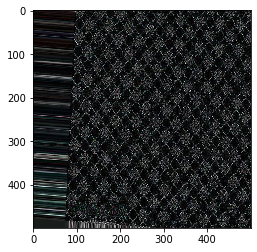

In [8]:
time_modelling_start = timeit.default_timer()
model["cap"] = []
model["tulis"] = []

def load_img(img_path):
    return Image.open(img_path).convert('L')

def get_img_size(img):
    return img.size

def print_img(img):
    plt.imshow(img)
    
def get_img_colors(img, sampling_count):
    img_width, img_height = get_img_size(img)
    
    sample_width = int(img_width / sampling_count)
    sample_height = int(img_height / sampling_count)
    
    half_sample_width = int(sample_width/2)
    half_sample_height = int(sample_height/2)

    img_colors = []

    width_constraint = img_width - (2 * sample_width)
    height_constraint = img_height - (2 * sample_height)
   
    row = 0
    for point_x in range(half_sample_width, img_width, sample_width):
        if(row == sampling_count):
            break
        column = 0
        for point_y in range(half_sample_height, img_height, sample_height):
            if(column == sampling_count):
                break
            img_colors.append(img.getpixel((point_x, point_y)))
                
            column += 1
                
        row += 1
            
    return img_colors

def construct_img(img_colors, img_dimension, sampling_count):
    img_new = Image.new('RGB', (img_dimension), (255, 255, 255))
    draw = ImageDraw.Draw(img_new)
    
    img_new_width = img_dimension[0]
    img_new_height = img_dimension[1]

    sample_width = int(img_new_width/sampling_count)
    sample_height = int(img_new_height/sampling_count)
    loop_count = 0

    img_colors_len = len(img_colors)

    for w in range(0, img_new_width, sample_width):
        for h in range(0, img_new_height, sample_height):
            if(loop_count == img_colors_len):
                break
            
            current_color = (img_colors[loop_count], img_colors[loop_count], img_colors[loop_count])
            draw.rectangle((w, h, w+sample_width, h+sample_height), fill=current_color)
            loop_count += 1
    
    return img_new

def get_3bit_colors(img_colors):
    loop_count = 0
    
    for img_color in img_colors:
        img_colors[loop_count] = map_8bit_to_3bit[img_color]
        
        loop_count += 1
        
    return img_colors

def get_img_matrix(img_colors):
    img_matrix = [] 
    loop_count = 0
    
    for row in range(8):
        new_img_matrix_row = []
        for col in range(8):
            new_img_matrix_row.append(img_colors[loop_count])
            
            loop_count += 1
        img_matrix.append(new_img_matrix_row)
        
    return img_matrix


    

#Features Extraction
        
def feature_extract(img, sampling_count):
    glcm_component=[]
    img_colors = get_img_colors(img, sampling_count)
    img_3bit_colors = get_3bit_colors(img_colors)
    img_matrix = get_img_matrix(img_3bit_colors)
    glcm_matrix=greycomatrix(img_matrix, distances=[1], angles=[0], levels=12, symmetric=False, normed=False)
    component = ['contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'dissimilarity']
    for x in component:
        glcm_component.append(greycoprops(glcm_matrix, x)[0][0])
    return(glcm_component)

    
#Modelling
def get_class_names(training_folder_path):
    return os.listdir(training_folder_path)

def make_a_model(class_name, features):
    model[class_name].append(features)
    

#Classification
def euclidian_distance(img_validate, img_model):
    distance = 0.0
    for i in range(len(img_validate)-1):
        distance += (img_validate[i] - img_model[i])**2
    return sqrt(distance)

def knn(img, sampling_count):
    min_distance = []
    class_min_distance = []
    k = 0
    img_validate = feature_extract(img, sampling_count)
    distance = 0.0
    for name_class in model:
        for img_train in model[name_class]:
            distance = euclidian_distance(img_validate, img_train)
            
            if(k<9):
                min_distance.append(distance)
                class_min_distance.append(name_class)
                k+=1
            else:
                for i in range (k):
                    if(distance<min_distance[i]):
                        min_distance[i] = distance
                        class_min_distance[i]= name_class
                        break
    
#     print(min_distance)
#     print(class_min_distance)
    predict_class = max(set(class_min_distance), key=class_min_distance.count)
#     print('Batik ini termasuk batik ' + predict_class)
    return predict_class
            

#Validation
def validate(sampling_count):
    right = 0.0;
    total = 0.0;
    accuracy = 0.0;
    class_names = get_class_names(validation_folder_path)
    for class_name in class_names:
        validate_img_paths = glob.glob(validation_folder_path + class_name + '/' +img_type)
        for validate_img_path in validate_img_paths:
            img_validate = load_img(validate_img_path)
            predict_class = knn(img_validate, sampling_count)
            class_image = class_name
            if(predict_class == class_image):
                right+=1
            total +=1
    accuracy = (right/total) * 100
    print("Accuracy: " + str(accuracy) +"%")
        

#Testing        
def testing(sampling_count):
    testing_img_paths = glob.glob(test_folder_path + '/' + img_type)
    for testing_img_path in testing_img_paths:
        imgs = load_img(testing_img_path)
        predict_class = knn(imgs, sampling_count)
        print("Categorized as " + predict_class)
        plt.imshow(Image.open(testing_img_path))    
        
        
#Training
sampling_count = 128
img_type = '*.jpg'
root_path = './'
training_folder_path = root_path + 'glcm/training/'
validation_folder_path = root_path + 'glcm/validation/'
test_folder_path = root_path + 'glcm/test/'

class_names = get_class_names(training_folder_path)

for class_name in class_names:
    training_img_paths = glob.glob(training_folder_path + class_name + '/' + img_type)

    for training_img_path in training_img_paths:
        training_img = load_img(training_img_path)
        training_img_class_name = class_name
        feature = feature_extract(training_img, sampling_count)
        make_a_model(class_name, feature)



# scaler = StandardScaler()
# for feature in model:
#     model[feature] = scaler.fit_transform(model[feature])
    
# print(model)


validate(sampling_count)

testing(sampling_count)


time_modelling_stop = timeit.default_timer()
print('Time elapsed to make this model is ' + str(time_modelling_stop - time_modelling_start) + ' seconds.')